In [18]:

import findspark
findspark.init()
# Import SparkSession
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType,BooleanType
from pyspark.sql.functions import *
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))



train_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date",DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("Sales", StringType(), True),
    StructField("onpromotion", StringType(), True)
])

holiday_schema  = StructType([
    StructField("Date", DateType(), True),
    StructField("type", StringType(), True),
    StructField("locale", StringType(), True),
    StructField("locale_name", StringType(), True),
    StructField("description", StringType(), True),
    StructField("transferred", BooleanType(), True)
])

oil_schema = StructType([
    StructField("date", DateType(), True),
    StructField("dcoilwtico", StringType(), True),
    
])

stores_schema = StructType([
    StructField("store_nbr", IntegerType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("type", StringType(), True),
    StructField("cluster", StringType(), True),
    
])

test_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("onpromotion", StringType(), True),
    
])

transactions_schema = StructType([
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("transactions", StringType(), True)
    
])



# Get path to directory (we all have unique paths to the repo)
__location__ = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('/home/robert/Downloads/store-sales-time-series-forecasting')))

# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("dataProject") \
      .getOrCreate() 


# Read in data (this method felt easy to understand, but is verbose)
train_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/train.csv",schema=train_schema,header=True)

holidays_events_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/holidays_events.csv",
schema=holiday_schema,header=True)

oil_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/oil.csv",schema=oil_schema,header=True)

stores_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/stores.csv",schema=stores_schema,header=True)

test_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/test.csv",schema=test_schema,header=True)

transactions_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/transactions.csv",
schema=transactions_schema,header=True)



# If you want to see how it looks like
#train_df.show()
#holidays_events_df.show()
#oil_df.show()
#stores_df.show()
#test_df.show()
#transactions_df.show()

In [19]:

total_records = train_df.count()
first_date = train_df.head()['date']
last_date = train_df.tail(1)[0].date

store_nbr_id = stores_df.select("store_nbr").distinct().count()
family_unique = train_df.select("family").distinct().count()
stores_city = stores_df.select("city").distinct().count()
stores_state = stores_df.select("state").distinct().count()




In [9]:
printmd("### Basic records:")
print("There are {} records, spanned from {} to {}.".format(total_records,first_date,last_date))

print("There are {} distinct stores.".format(store_nbr_id))
print("There are in total {} product families.".format(family_unique))
print("Thre are {} cities and {} states.".format(stores_city,stores_state))

### Basic records:

There are 3000888 records, spanned from 2013-01-01 to 2017-08-15.
There are 54 distinct stores.
There are in total 33 product families.
Thre are 22 cities and 16 states.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))




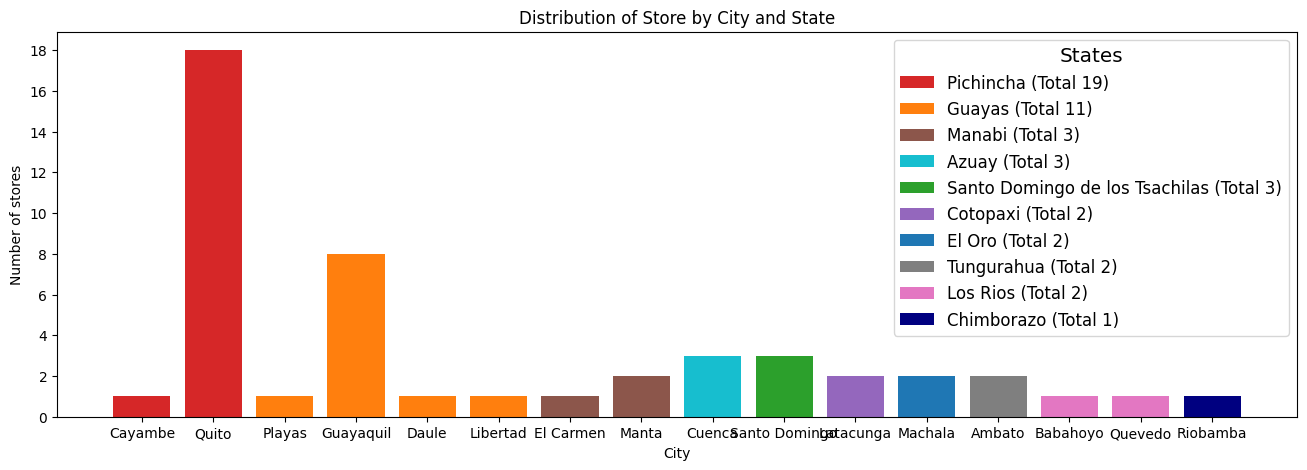

In [21]:
top_city_df = stores_df.groupBy('city').count().sort(desc("count"))
top_state_df = stores_df.groupBy('state').count().sort(desc("count"))
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()


stores_data_grouped = stores_df.groupBy(['state','city']).agg(count('city').alias('count'))

color = ["tab:red","tab:orange","tab:brown","tab:cyan","tab:green","tab:purple","tab:blue","tab:gray","tab:pink", "navy","darkred"]
fig, ax = plt.subplots( figsize=(16,5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Distribution of Store by City and State")
ax.set_ylabel("Number of stores")
ax.set_xlabel("City")
custom_label=[]
custom_legend = []
for i in range(0,10):
    u = stores_data_grouped.filter(stores_data_grouped.state == top_state[i][0])
    ax.bar(u.select(['city']).rdd.map(lambda r: r[0]).collect(), 
    u.select(['count']).rdd.map(lambda r: r[0]).collect(),color=color[i])
    custom_label.append ( Patch(facecolor=color[i])  )
    custom_legend.append( top_state[i][0] + " (Total {})".format(top_state[i][1]))
ax.legend(custom_label, custom_legend, fontsize="large", labelcolor="black", 
          fancybox=True, title = "States", title_fontsize = "x-large")
plt.show()




In [22]:
printmd("### Conclusion")
print("There are only 5 states with more than 2 stores.")
print("The top two states conatins the majority of the stores by big marginal.")

### Conclusion

There are only 5 states with more than 2 stores.
The top two states conatins the majority of the stores by big marginal.


In [23]:
sales_grouped = train_df.groupBy(['store_nbr','date']).agg(sum('sales').alias('sales'))
#sales_grouped.show()
sales_by_store_id = list()

for store in range(1,store_nbr_id+1):
    sales_by_store_id.append({'store':store,'sale':
    sales_grouped.filter(sales_grouped.store_nbr == store).select(avg("sales").alias('sales')).first()['sales'],
    'city':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city'],
    'city-id':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city']+"-{}".format(store),
    'state':stores_df.filter(stores_df.store_nbr == store).select('state').first()['state'],
    'type':stores_df.filter(stores_df.store_nbr == store).select('type').first()['type'],
    'cluster':stores_df.filter(stores_df.store_nbr == store).select('cluster').first()['cluster']})
sales_by_store_id = spark.createDataFrame(sales_by_store_id)
#sales_by_store_id.show()

In [24]:
from numpy import select


top_city = top_city_df.select(['city']).rdd.map(lambda r: r[0]).collect()

sales_by_city = list()
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()



for city_ in top_city:
    sales_by_city.append({'city':city_,
    'sum':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'sum'}).first()['sum(sale)'],
    'mean':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'avg'}).first()['avg(sale)']})
sales_by_city = spark.createDataFrame(sales_by_city)
#sales_by_city.show()


In [25]:
sales_by_store_id = sales_by_store_id.orderBy(['sale'],ascending=[False])
sales_by_city_sum = sales_by_city.orderBy(['sum'],ascending=[False])



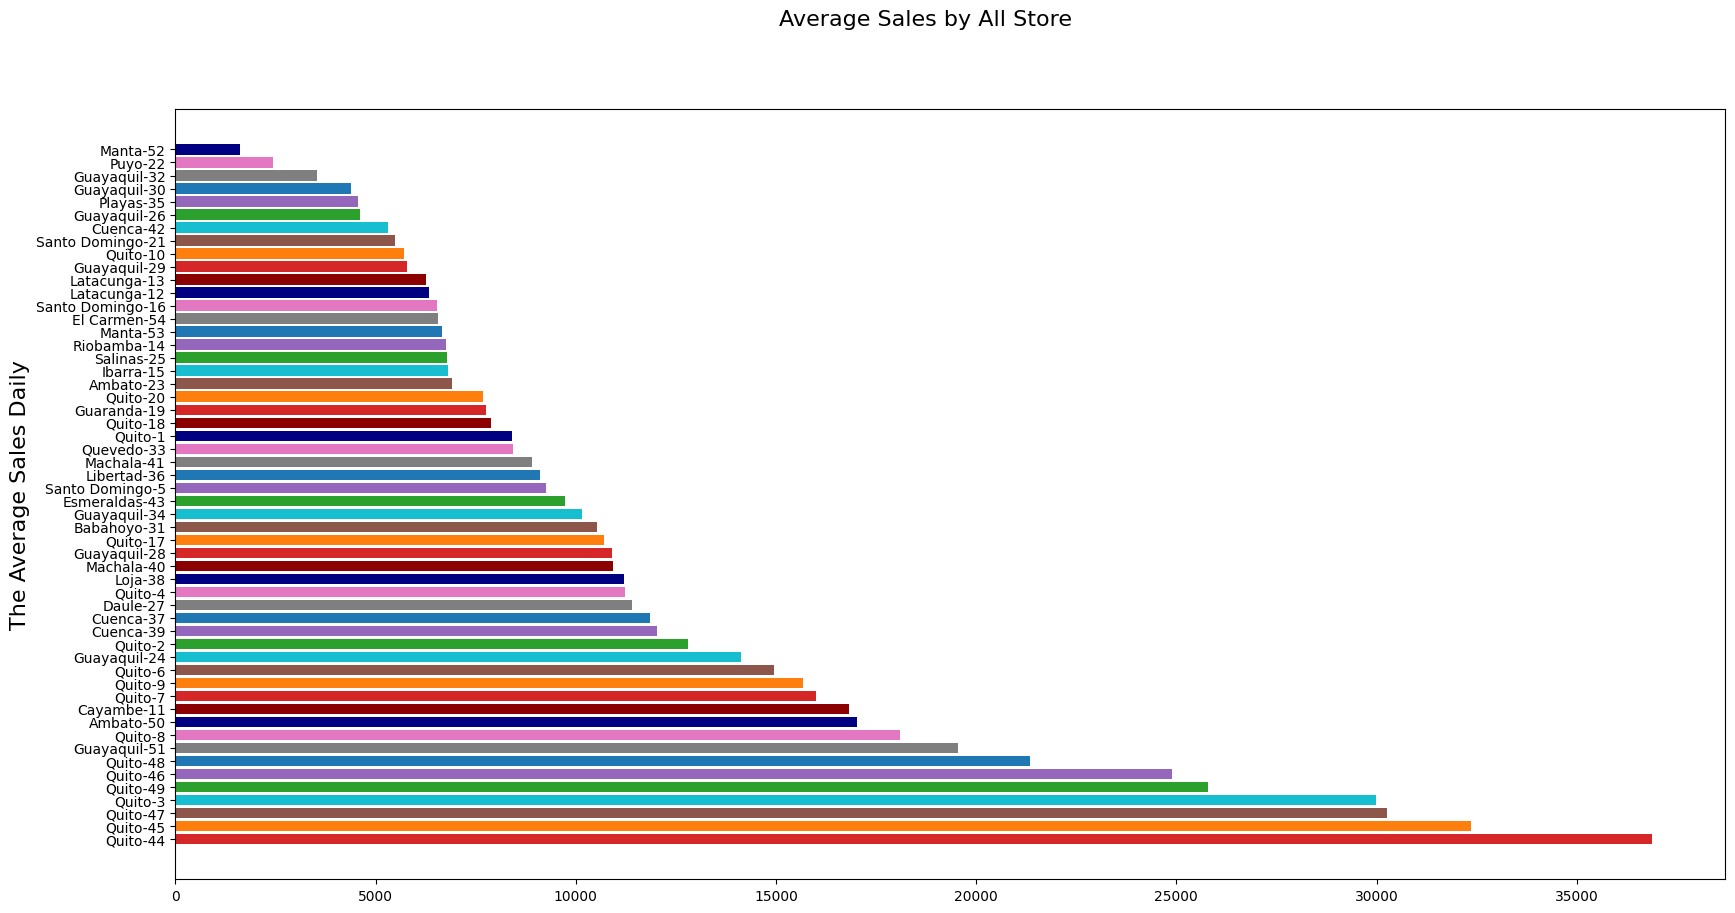

In [26]:
# Ploting
figsize = (20,10)
fig, ax0 = plt.subplots(figsize=figsize)
city_id = [val[0] for val in sales_by_store_id.select('city-id').collect()]
sale = [val[0] for val in sales_by_store_id.select('sale').collect()]
plt.barh(city_id,sale,color=color, align='center')
plt.suptitle("Average Sales by All Store",  fontsize=16, ha='center')
ax0.set_ylabel('The Average Sales Daily',  fontsize=16);
plt.show()

In [32]:
printmd("### Conclusion")
print("The most effective stores are located in Quito city.")
print("About 10 stores are running badly.")



### Conclusion

The most effective stores are located in Quito city.
About 10 stores are running badly.


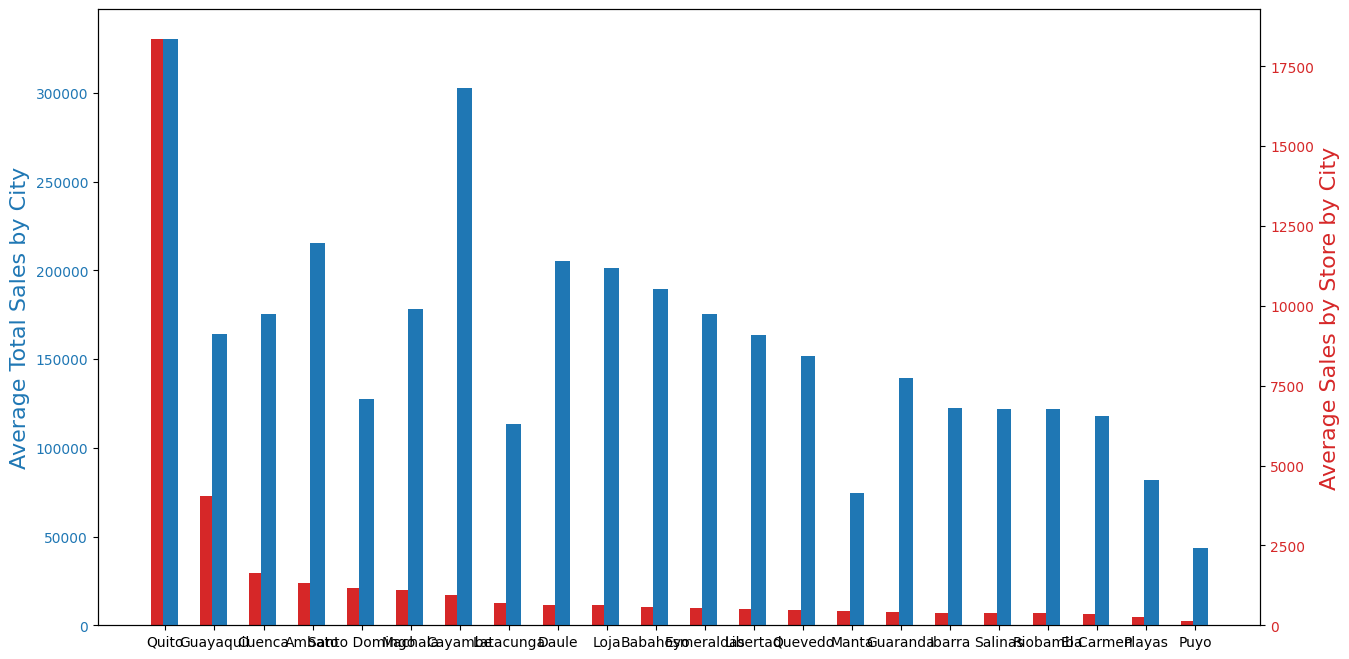

In [33]:
color2 = "tab:red"
color1 = "tab:blue"
fig,ax1= plt.subplots(figsize=figsize)
sum = [val[0] for val in sales_by_city_sum.select('sum').collect()]

mean = [val[0] for val in sales_by_city_sum.select('mean').collect()]
cities = [val[0] for val in sales_by_city_sum.select('city').collect()]
x = np.arange(len(cities))
plt.bar(x-0.1,sum,color=color2,width=0.4)
ax2 = ax1.twinx()

plt.bar(x+0.1,mean,color=color1,width=0.3)
plt.xticks(x,cities)

############# Style Set up ###############
ax1.set_ylabel('Average Total Sales by City', color=color1, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('Average Sales by Store by City', color=color2, fontsize=16)  
ax2.tick_params(axis='y', labelcolor=color2)

In [34]:
printmd("### Conclusion")
print("Quito has the biggest daily-average sales both per city and per store.")

### Conclusion

Quito has the biggest daily-average sales both per city and per store.


In [35]:
from pyspark.sql.window import Window
from pyspark.sql import functions as func

sales_grouped = train_df.groupBy('date').agg(func.sum('sales').alias('sales'))
sales_grouped = sales_grouped.orderBy('date',ascending=[True])
sales_grouped = sales_grouped.withColumn('year',year(sales_grouped.date))
sales_grouped = sales_grouped.withColumn('quarter',quarter(sales_grouped.date))
sales_grouped = sales_grouped.withColumn('month',month(sales_grouped.date))
sales_grouped = sales_grouped.withColumn("partition",lit("1"))



In [36]:

w=Window().partitionBy("partition").orderBy("date")
sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w7 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-6,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w7)).alias("L7D_moving_avg")).drop("rank")

sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w30 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-29,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w30)).alias("L30D_moving_avg")).drop("rank")

sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w365 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-364,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w365)).alias("L365D_moving_avg")).drop("rank")




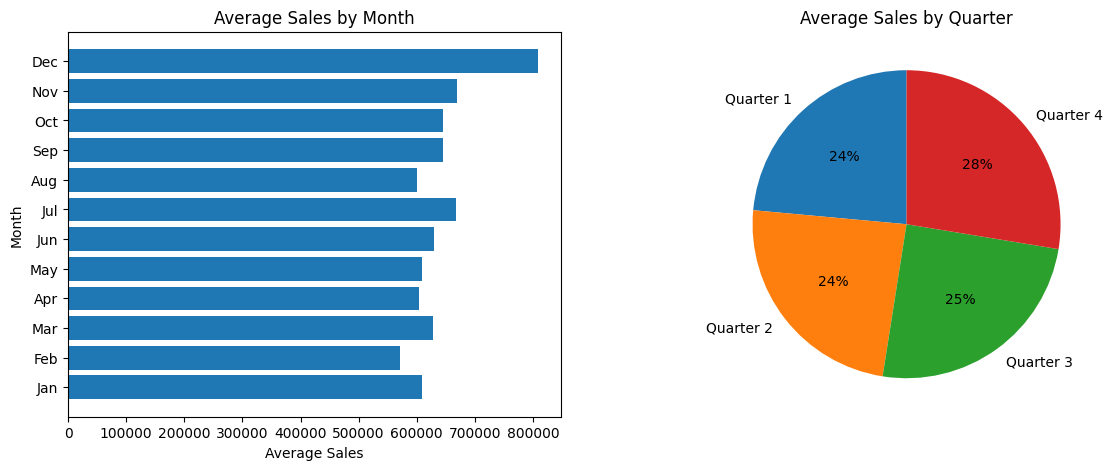

In [30]:
figsize = (14,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
df_plot_month = sales_grouped.groupBy('month').agg(func.avg('sales').alias('sales'))
df_plot_month = df_plot_month.orderBy(['month'],ascending=[True])

sales_month = [val[0] for val in df_plot_month.select('sales').collect()]
x_axis = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax1.set(title="Average Sales by Month")
ax1.set(ylabel="Month", xlabel="Average Sales")
ax1.barh(x_axis,sales_month)
ax2.set(title="Average Sales by Quarter")
df_plot_quarter = sales_grouped.groupBy('quarter').agg(func.avg('sales').alias('sales'))
df_plot_quarter = df_plot_quarter.orderBy(['sales'],ascending=[True])


sales_quarter = [val[0] for val in df_plot_quarter.select('sales').collect()]

ax2.pie(sales_quarter,autopct='%1.f%%',startangle=90,labels=["Quarter 1","Quarter 2","Quarter 3","Quarter 4"])

plt.show()


In [38]:
printmd("### Conclusion")
print("Most of the sales occurred in December.")
print("Although the sales in each quarter are very similar, the last 4th quarter is the biggest,")
print( "which agrees with the previous observation.")

### Conclusion

Most of the sales occurred in December.
Although the sales in each quarter are very similar, the last 4th quarter is the biggest,
which agrees with the previous observation.


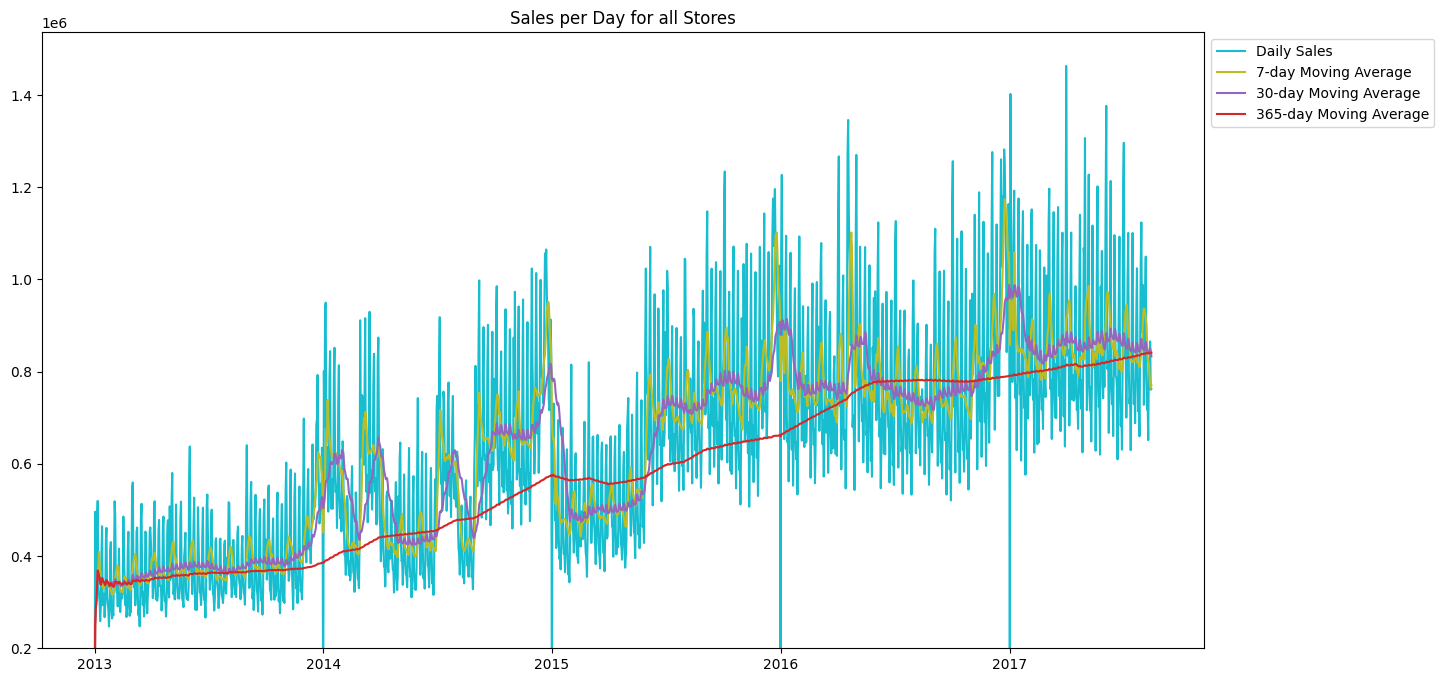

In [31]:
figsize = (15,8)
fig, ax = plt.subplots(figsize=figsize)
all_dates = [val[0] for val in sales_grouped.select('date').collect()]
normal_sales = [val[0] for val in sales_grouped.select('sales').collect()]
sales7 = [val[0] for val in sales_grouped.select('L7D_moving_avg').collect()]
sales30 = [val[0] for val in sales_grouped.select('L30D_moving_avg').collect()]

sales365 = [val[0] for val in sales_grouped.select('L365D_moving_avg').collect()]
ax.plot(all_dates,normal_sales,color="tab:cyan")
ax.plot(all_dates,sales7,color='tab:olive')
ax.plot(all_dates,sales30,color="tab:purple")
ax.plot(all_dates,sales365,color='tab:red')


ax.legend(["Daily Sales","7-day Moving Average","30-day Moving Average","365-day Moving Average"],bbox_to_anchor=(1.0, 1.0))
ax.set(ylim=2e5, title="Sales per Day for all Stores")

plt.show()


In [39]:
printmd("### Conclusion")
print("Based on the above graph, one can coclud that the sales were peaking at every new-year.")


### Conclusion

Based on the above graph, one can coclud that the sales were peaking at every new-year.


In [44]:

df_plot_2013 = sales_grouped.filter(sales_grouped.year == "2013").select(['date','sales','L30D_moving_avg'])
df_plot_2014 = sales_grouped.filter(sales_grouped.year == "2014").select(['date','sales','L30D_moving_avg'])
df_plot_2015 = sales_grouped.filter(sales_grouped.year == "2015").select(['date','sales','L30D_moving_avg'])
df_plot_2016 = sales_grouped.filter(sales_grouped.year == "2016").select(['date','sales','L30D_moving_avg'])
df_plot_2017 = sales_grouped.filter(sales_grouped.year == "2017").select(['date','sales','L30D_moving_avg'])

sales_2013 = [val[0] for val in df_plot_2013.select('sales').collect()]
sales_30_2013 = [val[0] for val in df_plot_2013.select('L30D_moving_avg').collect()]
dates_2013 = [val[0] for val in df_plot_2013.select('date').collect()]

sales_2014 = [val[0] for val in df_plot_2014.select('sales').collect()]
sales_30_2014 = [val[0] for val in df_plot_2014.select('L30D_moving_avg').collect()]
dates_2014 = [val[0] for val in df_plot_2014.select('date').collect()]

sales_2015 = [val[0] for val in df_plot_2015.select('sales').collect()]
sales_30_2015 = [val[0] for val in df_plot_2015.select('L30D_moving_avg').collect()]
dates_2015 = [val[0] for val in df_plot_2015.select('date').collect()]

sales_2016 = [val[0] for val in df_plot_2016.select('sales').collect()]
sales_30_2016 = [val[0] for val in df_plot_2016.select('L30D_moving_avg').collect()]
dates_2016 = [val[0] for val in df_plot_2016.select('date').collect()]

sales_2017 = [val[0] for val in df_plot_2017.select('sales').collect()]
sales_30_2017 = [val[0] for val in df_plot_2017.select('L30D_moving_avg').collect()]
dates_2017 = [val[0] for val in df_plot_2017.select('date').collect()]



Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


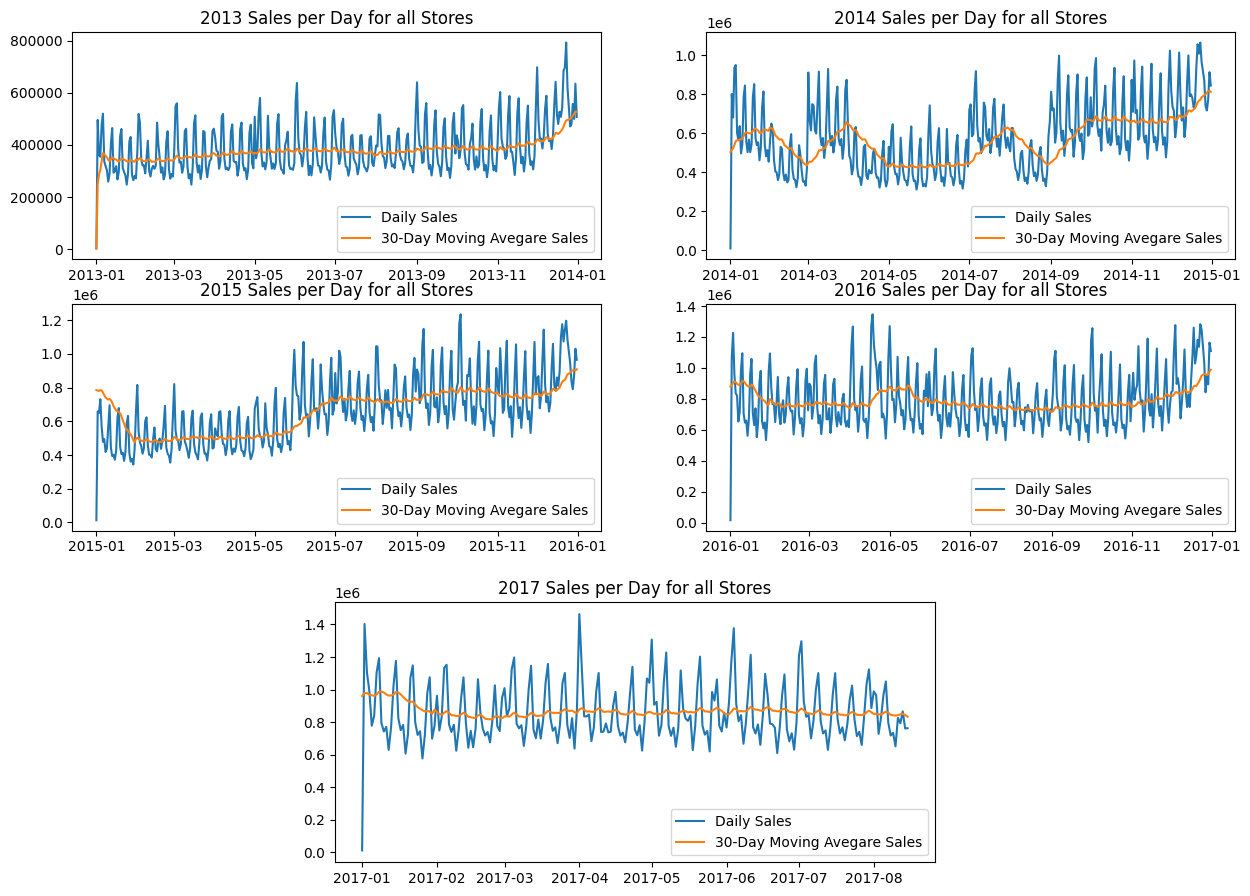

In [46]:
figsize = (16,5)
fig, ax = plt.subplots(3,2, figsize=(15,10))
ax[2][1].set_visible(False)
ax[2][0].set_position([0.30,0.05,0.4,0.26])


ax[0][0].plot(dates_2013,sales_2013)
ax[0][0].plot(dates_2013,sales_30_2013)

ax[0][0].legend(["Daily Sales","30-Day Moving Avegare Sales"])
ax[0][0].set(title="2013 Sales per Day for all Stores")

ax[0][1].plot(dates_2014,sales_2014)
ax[0][1].plot(dates_2014,sales_30_2014)

ax[0][1].legend(["Daily Sales","30-Day Moving Avegare Sales"])
ax[0][1].set(title="2014 Sales per Day for all Stores")

ax[1][0].plot(dates_2015,sales_2015)
ax[1][0].plot(dates_2015,sales_30_2015)

ax[1][0].legend(["Daily Sales","30-Day Moving Avegare Sales"])
ax[1][0].set(title="2015 Sales per Day for all Stores")

ax[1][1].plot(dates_2016,sales_2016)
ax[1][1].plot(dates_2016,sales_30_2016)

ax[1][1].legend(["Daily Sales","30-Day Moving Avegare Sales"])
ax[1][1].set(title="2016 Sales per Day for all Stores")

ax[2][0].plot(dates_2017,sales_2017)
ax[2][0].plot(dates_2017,sales_30_2017)

ax[2][0].legend(["Daily Sales","30-Day Moving Avegare Sales"])
ax[2][0].set(title="2017 Sales per Day for all Stores")

plt.show()

In [41]:
printmd("### Conclusion")
print("By examing the peeks of the above graphs one can coclude that there are a monthly frequency")

### Conclusion

By examing the peeks of the above graphs one can coclude that there are a monthly frequency


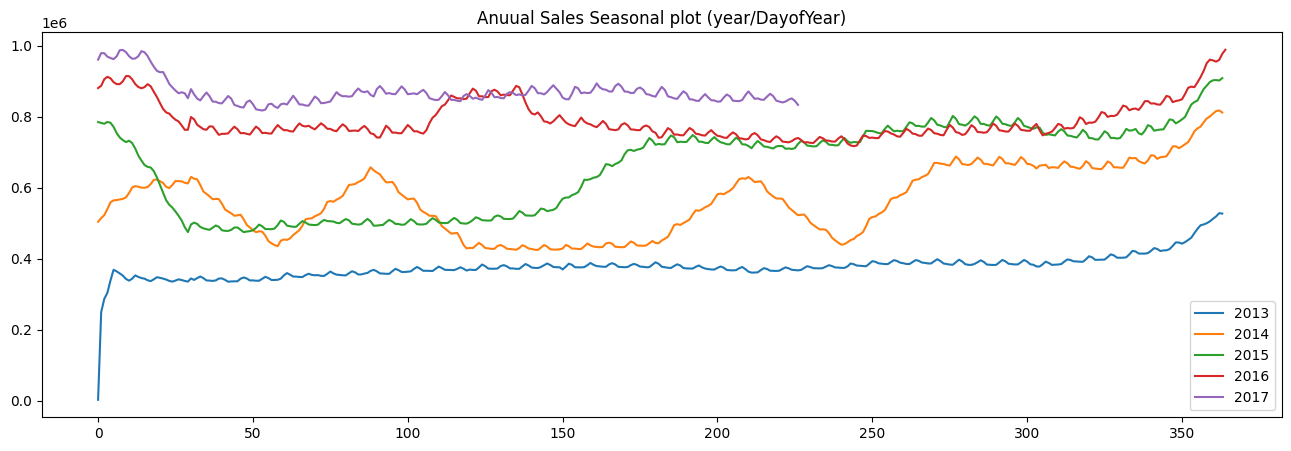

In [47]:
figsize = (16,5)
fig, ax = plt.subplots(figsize=figsize)

x = np.arange(0,len(dates_2014))
x1 = np.arange(0,len(dates_2016))
x2 = np.arange(0,len(dates_2017))
ax.plot(x,sales_30_2013)
ax.plot(x,sales_30_2014)
ax.plot(x,sales_30_2015)
ax.plot(x1,sales_30_2016)
ax.plot(x2,sales_30_2017)


ax.legend(["2013","2014","2015","2016","2017"])
ax.set(title="Anuual Sales Seasonal plot (year/DayofYear)")

plt.show()

In [ ]:
printmd("### Conclusion")
print("By examining the above plot one could result that there are a general pattern in periodicity,")
print("with some abnormalities which could be resulted from external factors.")